In [7]:
import os
import torch
import torchvision

import torchvision.transforms as transforms
import numpy as np
import matplotlib.pylab as plt

from utils import compute_confusion_matrix, train, evaluate
from networks import ConvolutionalNN

# Define hyperparameters etc.

In [79]:
# pendulum
m = 1.
g = 9.81
l = 1.
dt = 1e-2

num_examples = 1000
sequence_len = 100

batch_size = 32
learning_rate = 0.001
num_epochs = 1
filter_shapes = [(1, 8, 5), (8, 16, 5), (16, 64, 5), (64, 16, 5), (16, 8, 5)]
outdim = 10
print_every = 100

# Dataset

In [100]:
def compute_dynamical_update(state, g, l):
    '''
    
    Arguments:
    ---------
    
    Returns:
    -------
    '''
    theta, d_theta = np.split(state, indices_or_sections=2, axis=-1)
    d2_theta = -g/l * np.sin(theta)
    # print(np.sin(theta))
    # print(d_theta.shape, d2_theta.shape)
    
    return np.hstack((d_theta, d2_theta))


def sym_euler_update(state, d_state, dt):
    '''
    '''
    theta, d_theta = np.split(state, indices_or_sections=2, axis=-1)
    _, d2_theta = np.split(d_state, indices_or_sections=2, axis=-1)

    d_theta_next = d_theta + dt * d2_theta
    theta_next = theta + dt * d_theta

    next_state = np.hstack((theta_next, d_theta_next))
    
    return next_state


def normalize_state(state):
    '''
    '''
    theta, d_theta = np.split(state, indices_or_sections=2, axis=-1)
    pass

def generate_dataset(num_examples, sequence_len, g, l, dt):
    '''
    '''
    theta_0 = np.random.uniform(-np.pi, np.pi, size=(num_examples, 1))
    d_theta_0 = np.random.uniform(-1., 1., size=(num_examples, 1))
    # print(theta_0.shape, d_theta_0.shape)
    init_cond = np.hstack((theta_0, d_theta_0))
    # print(init_cond.shape)
    
    data = [init_cond]
    for i in range(sequence_len - 1):
        cur_state = data[-1]
        dynamical_update = compute_dynamical_update(cur_state, g, l)
        next_state = sym_euler_update(cur_state, dynamical_update, dt)
        data.append(next_state)
    
    data = np.asarray(data) # shape - sequence_len x num_examples x state_dim
    new_idx_order = [1, 0, 2]
    data = np.transpose(data, new_idx_order) # shape - num_examples x sequence_len x state_dim
    
    return data

In [101]:
dataset = generate_dataset(num_examples, sequence_len, g, l, dt)

Text(0, 0.5, 'theta_dot')

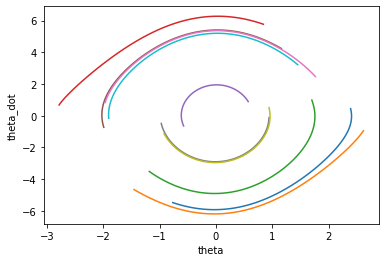

In [102]:
dataset.shape
idx = np.random.randint(num_examples, size=10)
for i in idx:
    trajectory = dataset[i].T
    plt.plot(trajectory[0], trajectory[1])
    
plt.xlabel('theta')
plt.ylabel('theta_dot')

# Recurrent neural network

In [ ]:
class RecurrentNN(torch.nn.Module):
    def __init__(self, indim, hdim, outdim, sequence_len):
        self.indim = indim
        self.hdim = hdim
        self.outdim = outdim
        self.sequence_len = sequence_len
        
        self.W_h = torch.nn.Linear(indim, hdim)
        self.U_h = torch.nn.Linear(hdim, hdim)
        self.W_y = torch.nn.Linear(hdim, outdim)
        
        self.RNN = RecurrentCell(W_h, U_h, W_y)
            
    
    def forward(self, x):
        batch_size, dim = x.shape
        init_hidden = torch.zeros(batch_size, self.hdim)
        
        hidden = [init_hidden]
        outputs = [torch.zeros_like(x)]
        for t in range(self.sequence_len):
            out, h = self.RNN(x[:, t, :], hidden[-1])
            hidden.append(h)
            outputs.append(out)
            
        return hidden, outputs
    
    
class RecurrentCell(torch.nn.Module):
    def __init__(self, W_h, U_h, W_y):
        self.W_h = W_h
        self.U_h = U_h
        self.W_y = W_y
        
    def forward(self, x_cur, h_cur):
        '''
        h_t = sigma_h( W_h x_t + U_h h_{t-1} + b_h ) 
        y_t = sigma_y( W_y h_t + b_y )
        '''
        
        # each linear has a bias
        h_next = torch.sigma(torch.dot(self.W_h, x_cur) + torch.dot(self.U_h, h_cur))
        x_hat_next = torch.sigma(torch.dot(self.W_y, h_cur))
        
        return x_hat_next, h_next
        

In [ ]:
convnet = ConvolutionalNN(filter_shapes, outdim)

In [ ]:
params = convnet.parameters()
num_params = np.sum([np.prod(p.shape) for p in params])
print('The number of parameters in the network is: {}'.format(num_params))

In [ ]:
loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convnet.parameters(), lr=learning_rate)

In [ ]:
# create dataloader
trainloader = torch.utils.data.DataLoader(emnist_traindata, batch_size=batch_size, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(emnist_testdata, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
# make weights trainable
convnet.train()

# run training loop
training_loss = train(num_epochs, print_every, trainloader, loss_fcn, optimizer, convnet)

In [ ]:
# plot training loss
plt.plot(training_loss)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')

In [ ]:
convnet.eval()

average_accuracy, average_loss, prediction_label_data = evaluate(testloader, loss_fcn, convnet)
    
print('Avg Loss: {loss:.2f}, Avg Acc: {acc:.2f}'.format(loss=average_loss, acc=average_accuracy))

In [ ]:
confusion_matrix, mistakes = compute_confusion_matrix(prediction_label_data)
# get image with wrong prediction
mistake_idx = np.random.randint(len(mistakes))
mistake_pred, mistake_label, mistake_data = mistakes[mistake_idx]
mistake_img = mistake_data.squeeze().T

plt.subplot(121)
plt.imshow(np.log(confusion_matrix))
plt.title('Log Confusion matrix')
plt.xlabel('label')
plt.ylabel('prediction')

plt.subplot(122)
plt.imshow(mistake_img)
plt.title('Label: {label}, Prediction {pred}'.format(label=mistake_label, pred=mistake_pred))